<h2> Two Mirror Cavity Dynamics</h2>
This notebook tests the ability of finesse to compute the eigenmode change of a linear cavity as a result of an optic being pitched or yawed.

In [1]:
import pykat
from pykat import finesse
from pykat.commands import *
import matplotlib.pyplot as plt
import numpy as np

plt.rc('font', size= 20)
plt.rc('axes', titlesize= 20)

                                              ..-
    PyKat 1.1.331         _                  '(
                          \`.|\.__...-""""-_." )
       ..+-----.._        /  ' `            .-'
   . '            `:      7/* _/._\    \   (
  (        '::;;+;;:      `-"' =" /,`"" `) /
  L.        \`:::a:f            c_/     n_'
  ..`--...___`.  .    ,
   `^-....____:   +.      www.gwoptics.org/pykat



<h2> Analytical Solution </h2>
Here we look at the expected translation of a cavity axis using geometrical arguments. All formulas and how they arise can be found in Siegman chapter 19. The index for each variable indicates which optic we are referring to.

In [220]:
# Mirror Tilt:
theta_1 = 0#1e-6                    # M1 tilt 
theta_2 = 1e-6                  # M2 tilt 
w0 = 260.26206750103e-6                     # Beam waist
F = 625.17
lam = 1064e-9

# Cavity parameters:
L = 0.1                        # Cavity Length
RcM2 = 0.5                     # Radius of curvature of M2 mirror =0.5 m
g1 = 1                         # g1 = 1 - L/RcM1 = 1 since RcM1 = infinity
g2 = 1 - L/RcM2                # g2 for M2 mirror
print('g1g2 =', g1*g2)         # Stability check

# Resulant translation 
delta_x1 = (g2/(1-g1*g2))*L*theta_1 + (1/(1- g1*g2))*L*theta_2    # Displacement on M1
delta_x2 = (1/(1-g1*g2))*L*theta_1 + (g1/(1-g1*g2))*L*theta_2     # Displacement on M2
delta_theta = (delta_x2 - delta_x1)/L                             # Angular displacement of optical axis

print('Results for analytical solutions:')
print('∆x1: ', delta_x1, ' m')
print('∆x2: ', delta_x2, ' m')
print(r'∆θ: ', delta_theta, ' m')

g1g2 = 0.8
Results for analytical solutions:
∆x1:  5.000000000000001e-07  m
∆x2:  5.000000000000001e-07  m
∆θ:  0.0  m


<h2> Finesse Solution </h2>
Now we use finesse to model the same cavity.

4.987301100711592e-07 -4.470668607854657e-07


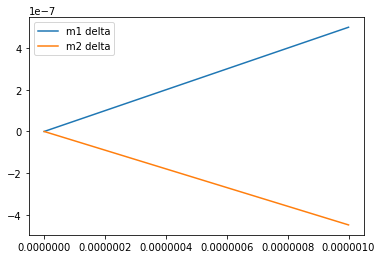

In [258]:
# Finesse Solution
base = finesse.kat()
base.verbose=False
base.parse(
"""
l laser 1 0 n0              # Laser 1W
s s0 1 n0 n1                # Distance from the laser to the first mirror M1
    
#Cavity:
m M1 0.99 0.01 0 n1 n2            # Cavity mirror M1: R = 0.99, T = 0.01
s s_cav 0.1 n2 n3           # Cavity Length: L =  0.1 m
m M2 1 0 0 n3 n4            # Cavity mirror M2: R = 1, T = 0
attr M2 Rc 0.5              # Radius of curvature of M2 = 0.5 m
cav cavity M1 n2 M2 n3      
"""
)

base.maxtem = 3
base.trace = 2

# We need amplitude detectors for the HG00, HG01, and HG10 modes in order to measure translation
kat = base.deepcopy()
kat.noxaxis = True
kat.parse(
"""
# Mirror Movement
# attr M2 xbeta 1u

# Detectors:

pd pd00 n2
ad det01refl 0 1 0 n1

# y detectors
ad d00m2 0 0 0 n3
ad d00m1 0 0 0 n2
ad d01m2 0 1 0 n3
ad d01m1 0 1 0 n2

# x detectors
ad d10m2 1 0 0 n3
ad d10m1 1 0 0 n2

bp w0 x w0 n3
    
# Mirror tilt and axes
xaxis M2 xbeta lin 0 1u 100

yaxis re:im
""")
out = kat.run()

w0 = out['w0'].real

p00 = out['pd00'].real
a00 = np.sqrt(p00)

refl01 = out['det01refl']

abs00m2 = abs(out['d00m2'])
abs01m2 = abs(out['d01m2'])

abs00m1 = abs(out['d00m1'])
abs01m1 = abs(out['d01m1'])

# print (a00-abs00m1-abs01m1) # power minus amplitude of modes

re00m1 = out['d00m1'].real
re01m1 = out['d01m1'].real
re01m2 = out['d01m2'].real

im00m1 = out['d00m1'].imag
im01m1 = out['d01m1'].imag
im01m2 = out['d01m2'].imag

re00m1 = out['d00m1'].real
re10m1 = out['d10m1'].real
re10m2 = out['d10m2'].real

im00m1 = out['d00m1'].imag
im10m1 = out['d10m1'].imag
im10m2 = out['d10m2'].imag



atransm1_x = im10m1/a00*w0
atransm2_x = im10m2/a00*w0



# print (max(atransm1)/delta_x1)
# print (delta_x2/max(atransm2))


# out.plot(detectors = ['d01m1','d01m2'])

# plt.figure()
# plt.plot(out.x,abs00) # 00 mode amplitude
# plt.figure()
# plt.plot(out.x,abs01m2/abs00m2*w0) #01 mode delta
# plt.plot(out.x,abs01m1/abs00m1*w0)


plt.figure()
plt.plot(out.x,atransm1_x, label='m1 delta')
plt.plot(out.x,atransm2_x, label='m2 delta')
# plt.plot(out.x,refl01.real, label = 'refl 01 real')
# plt.plot(out.x,refl01.imag, label = 'refl 01 imag')
plt.legend()

print (max(atransm1_x),min(atransm2_x))

In [40]:
dir(out)

['StartDateTime',
 '____FROZEN____',
 '__class__',
 '__contains__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_freeze',
 '_unfreeze',
 'get',
 'info',
 'katScript',
 'katVersion',
 'loadKatRun',
 'plot',
 'runDateTime',
 'runtime',
 'saveKatRun',
 'stderr',
 'stdout',
 'x',
 'xlabel',
 'y',
 'yaxis',
 'ylabels']

In [268]:
print (.1*(.5)**4)
print (5e-3/.00625)
#input power  40W
print (.8/40)
print (0.02*125)
#look at LLO ham1

0.00625
0.7999999999999999
0.02
2.5
